# Import Nesessary Librries

In [1]:
# Importing necessary libraries for data manipulation and analysis

import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis

# Importing libraries for deep learning model creation and training
import tensorflow as tf  # TensorFlow for deep learning
from tensorflow.keras.models import Sequential  # Sequential model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout  # Layers for the model
from tensorflow.keras.optimizers import Adam  # Optimizer for the model
from tensorflow.keras.callbacks import EarlyStopping # Callback for early stopping

# Importing libraries for machine learning model evaluation
from sklearn.model_selection import train_test_split  # For splitting data into train and test sets
from sklearn.metrics import classification_report, accuracy_score  # For evaluating the model

# Importing libraries for NLP and transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification  # Tokenizer and model for sequence classification

# Importing libraries for PyTorch
import torch  # PyTorch for deep learning
from torch.utils.data import DataLoader, Dataset  # DataLoader and Dataset for handling data

# Importing libraries for visualization
import matplotlib.pyplot as plt  # For plotting graphs

# Importing libraries for handling JSON data
import json  # For handling JSON data

# Importing NLTK for natural language processing
import nltk  # Natural Language Toolkit
from nltk.corpus import stopwords # For removing stopwords
from nltk.stem import WordNetLemmatizer # For lemmatizing words

import joblib  # For saving and loading models

/Users/uvaishnav/fake_product_review_detection/fakeenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## NLTK Recourses for preprocessing

In [2]:
nltk.download('stopwords') # Downloads the list of stopwords, which are common words that are usually removed in text preprocessing.
nltk.download('wordnet') # Downloads the WordNet lexical database, which is used for finding synonyms, antonyms, and other lexical relations.
nltk.download('omw-1.4') # Downloads the Open Multilingual Wordnet package, which provides multilingual WordNet data.

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/uvaishnav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/uvaishnav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/uvaishnav/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/ # Unzips the WordNet data

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


# Load Dataset

In [4]:
data = pd.read_csv("fake reviews dataset.csv")
data.head() # Displays the first few rows of the dataset

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


# Cleaning Data

In [5]:
data.drop(columns = {'category'}, inplace = True)

In [6]:
data.rename(columns = {'text_': 'text'}, inplace = True) 

In [7]:
data.head()

,rating,label,text
0,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,5.0,CG,"love it, a great upgrade from the original. I..."
2,5.0,CG,This pillow saved my back. I love the look and...
3,1.0,CG,"Missing information on how to use it, but it i..."
4,5.0,CG,Very nice set. Good quality. We have had the s...


In [8]:
def encode_label(df):
    labels = {
        'CG': 0,
        'OR': 1
    }
    
    df['target'] = df['label'].map(labels)
    
    return df

In [9]:
data = encode_label(data)
data = encode_label(data)

# Fill any NaN values in the 'target' column with 0 and replace any infinite values with 0
data['target'] = data['target'].fillna(0).replace([np.inf, -np.inf], 0)

# Convert the 'target' column to integer type
data['target'] = data['target'].astype(int)

In [10]:
data.drop(columns = {'rating', 'label'}, inplace = True)

In [11]:
data = data.sample(frac=1).reset_index(drop=True)

data.head()

,text,target
0,"We had 3 of these someone gave us for xmas, or...",1
1,"Sad that catholics in america, who have eaten ...",1
2,This is just what I needed. The only problem i...,0
3,YOU WILL NOT FIND A LOT OF TURNERS. I saw a lo...,0
4,To my surprise this was much nicer than the tr...,1


In [12]:
data.isnull().sum()

text      0
target    0
dtype: int64

In [13]:
data.duplicated().sum()

np.int64(20)

In [14]:
data.drop_duplicates(inplace = True)
data.duplicated().sum()

np.int64(0)

In [15]:
data['target'].value_counts()

target
1    20215
0    20197
Name: count, dtype: int64

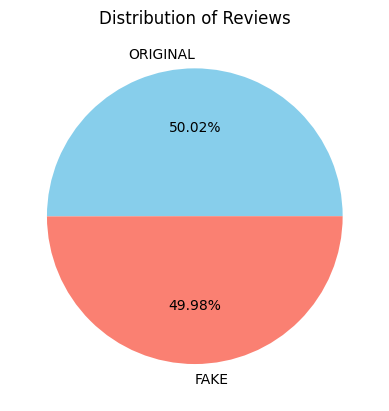

In [16]:
plt.pie(data['target'].value_counts(), labels = ['ORIGINAL', 'FAKE'], autopct = '%.2f%%', colors = ['skyblue', 'salmon'])
plt.title('Distribution of Reviews')
plt.show()

# Preprocessing

In [17]:
def clean_text(text):
    """
    Cleans the input text by performing the following operations:
    1. Converts the text to lowercase.
    2. Removes all non-alphanumeric characters except spaces.
    3. Removes stopwords (common words that do not contribute much meaning).
    4. Lemmatizes the words (reduces words to their base or root form).

    Args:
        text (str): The input text to be cleaned.

    Returns:
        str: The cleaned text.
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

In [18]:
data['text'] = data['text'].apply(clean_text)

In [19]:
data.head()

,text,target
0,3 someone gave u xmas wtvr long time ago tosse...,1
1,sad catholic america eaten heartily protestant...,1
2,needed problem kind hard put bottom top,0
3,find lot turner saw lot review,0
4,surprise much nicer true spec much better stit...,1


## Split the Dataset

In [20]:
# Split the dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text'], data['target'], test_size=0.2, random_state=42
)

# Further split the testing set into validation and testing sets
val_texts, test_texts, val_labels, test_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, random_state=42
)

# Tokenization

### parameters for the tokenizer

In [21]:
# Define the maximum vocabulary size for the tokenizer
max_vocab_size = 10000

# Define the maximum sequence length for the input sequences
max_sequence_length = 100

In [22]:
# Initialize the tokenizer with a maximum vocabulary size and an out-of-vocabulary token
lstm_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")

# Fit the tokenizer on the training texts
lstm_tokenizer.fit_on_texts(train_texts)

# Save the tokenizer to a file
joblib.dump(lstm_tokenizer, 'lstm_tokenizer.pkl')

['lstm_tokenizer.pkl']

In [23]:
# Convert the training texts to sequences of integers
train_sequences = lstm_tokenizer.texts_to_sequences(train_texts)
test_sequences = lstm_tokenizer.texts_to_sequences(test_texts)
val_sequences = lstm_tokenizer.texts_to_sequences(val_texts)

# Pad the sequences to ensure that they are all the same length
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
val_padded = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Train Model

### Hyperparameter search space for LSTM

In [24]:
learning_rates = [1e-3, 1e-4, 1e-5]
batch_sizes = [16, 32, 64]
dropout_rates = [0.2, 0.3, 0.5]

### Define the EarlyStopping callback

In [25]:
early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=5,          # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restore the weights of the epoch with the best validation loss
    )

### Getting subset of the Dataset for hyperparameter tuning

In [26]:
def get_tuning_subset(X_train, y_train, X_val, y_val, X_test, y_test, subset_size=0.10):
    """
    Creates a smaller subset of the training, validation, and test sets for hyperparameter tuning,
    while preserving class distributions.

    Args:
        X_train, y_train: Training data and labels.
        X_val, y_val: Validation data and labels.
        X_test, y_test: Test data and labels.
        subset_size: The fraction of data to include in the subset (e.g., 0.1 for 10%).

    Returns:
        X_train_subset, y_train_subset, X_val_subset, y_val_subset, X_test_subset, y_test_subset
    """

    X_train_subset, _, y_train_subset, _ = train_test_split(
        X_train, y_train, train_size=subset_size, stratify=y_train, random_state=42
    )

    X_val_subset, _, y_val_subset, _ = train_test_split(
        X_val, y_val, train_size=subset_size, stratify=y_val, random_state=42
    )

    X_test_subset, _, y_test_subset, _ = train_test_split(
        X_test, y_test, train_size=subset_size, stratify=y_test, random_state=42
    )

    return X_train_subset, y_train_subset, X_val_subset, y_val_subset, X_test_subset, y_test_subset


In [27]:
X_train_sub, y_train_sub, X_val_sub, y_val_sub, X_test_sub, y_test_sub = get_tuning_subset(
    train_padded, train_labels, val_padded, val_labels, test_padded, test_labels
)

### Experimentation function for LSTM

In [28]:
def tune_lstm_model(lr, batch_size, dropout_rate):
    """
    Tunes an LSTM model with the given hyperparameters and evaluates its performance.

    Args:
        lr (float): Learning rate for the optimizer.
        batch_size (int): Batch size for training.
        dropout_rate (float): Dropout rate for regularization.

    Returns:
        dict: Classification report containing precision, recall, f1-score, and support for each class.
    """
    # Define the LSTM model architecture
    lstm_model = Sequential([
        # Embedding layer to convert input sequences into dense vectors of fixed size
        Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_sequence_length),
        # First LSTM layer with 128 units, returning sequences for the next LSTM layer
        LSTM(128, return_sequences=True),
        # Dropout layer for regularization to prevent overfitting
        Dropout(dropout_rate),
        # Second LSTM layer with 64 units
        LSTM(64),
        # Dropout layer for regularization
        Dropout(dropout_rate),
        # Dense layer with 32 units and ReLU activation
        Dense(32, activation='relu'),
        # Output layer with 2 units (for 2 classes) and softmax activation
        Dense(2, activation='softmax')
    ])
    
    # Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
    lstm_model.compile(optimizer=Adam(learning_rate=lr), 
                       loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the training data and validate on the validation data
    lstm_model.fit(X_train_sub, y_train_sub, validation_data=(X_val_sub, y_val_sub), 
                   epochs=20, batch_size=batch_size, callbacks=[early_stopping])
    
    # Predict the labels for the test data
    lstm_predictions = np.argmax(lstm_model.predict(X_test_sub), axis=1)
    
    # Return the classification report for the test data
    return classification_report(y_test_sub, lstm_predictions, output_dict=True)

### Run experiments for LSTM

In [ ]:
# Initialize dictionaries to store results and track the best hyperparameters
lstm_results = {}
best_lstm_metrics = None
best_lstm_hyperparameters = None

# Iterate over all combinations of learning rates, batch sizes, and dropout rates
for lr in learning_rates:
    for batch_size in batch_sizes:
        for dropout_rate in dropout_rates:
            print(f"Tuning LSTM: LR={lr}, Batch Size={batch_size}, Dropout={dropout_rate}")
            
            # Tune the LSTM model with the current set of hyperparameters
            result = tune_lstm_model(lr, batch_size, dropout_rate)
            
            # Store the result in the dictionary with the hyperparameters as the key
            lstm_results[(lr, batch_size, dropout_rate)] = result
            
            # Calculate the average F1 score from the classification report
            avg_f1_score = result['weighted avg']['f1-score']
            
            # Update the best metrics and hyperparameters if the current model is better
            if best_lstm_metrics is None or avg_f1_score > best_lstm_metrics:
                best_lstm_metrics = avg_f1_score
                best_lstm_hyperparameters = (lr, batch_size, dropout_rate)

### Summarize results for LSTM

In [30]:
def summarize_results(results, model_name="LSTM"):
    """
    Summarizes the results of model experiments by printing the precision, recall, and F1-score
    for each set of hyperparameters.

    Args:
        results (dict): A dictionary where keys are hyperparameter tuples and values are classification reports.
        model_name (str): The name of the model being summarized (default is "LSTM").
    """
    for key, value in results.items():
        print(f"Hyperparameters: {key} - {model_name}")
        print(f"Precision: {value['weighted avg']['precision']:.4f}")
        print(f"Recall: {value['weighted avg']['recall']:.4f}")
        print(f"F1-score: {value['weighted avg']['f1-score']:.4f}")
        print("-" * 50)

In [31]:
summarize_results(lstm_results, model_name="LSTM")

Hyperparameters: (0.001, 16, 0.2) - LSTM
Precision: 0.8446
Recall: 0.8441
F1-score: 0.8439
--------------------------------------------------
Hyperparameters: (0.001, 16, 0.3) - LSTM
Precision: 0.8236
Recall: 0.8168
F1-score: 0.8156
--------------------------------------------------
Hyperparameters: (0.001, 16, 0.5) - LSTM
Precision: 0.2426
Recall: 0.4926
F1-score: 0.3251
--------------------------------------------------
Hyperparameters: (0.001, 32, 0.2) - LSTM
Precision: 0.7591
Recall: 0.7550
F1-score: 0.7536
--------------------------------------------------
Hyperparameters: (0.001, 32, 0.3) - LSTM
Precision: 0.7872
Recall: 0.7178
F1-score: 0.6981
--------------------------------------------------
Hyperparameters: (0.001, 32, 0.5) - LSTM
Precision: 0.8213
Recall: 0.8193
F1-score: 0.8192
--------------------------------------------------
Hyperparameters: (0.001, 64, 0.2) - LSTM
Precision: 0.7929
Recall: 0.7921
F1-score: 0.7918
--------------------------------------------------
Hyperp

#### Display best results for LSTM


In [32]:
print("Best LSTM Hyperparameters:", best_lstm_hyperparameters)
print("Best LSTM F1-Score:", best_lstm_metrics)

Best LSTM Hyperparameters: (0.001, 16, 0.2)
Best LSTM F1-Score: 0.8439302455562905



## Retrain LSTM model with best hyperparameters

In [33]:
# Extract the best hyperparameters from the tuning results
best_lr, best_batch_size, best_dropout_rate = best_lstm_hyperparameters

# Define the LSTM model architecture using the best hyperparameters
best_lstm_model = Sequential([
    # Embedding layer to convert input sequences into dense vectors of fixed size
    Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_sequence_length),
    # First LSTM layer with 128 units, returning sequences for the next LSTM layer
    LSTM(128, return_sequences=True),
    # Dropout layer for regularization to prevent overfitting
    Dropout(best_dropout_rate),
    # Second LSTM layer with 64 units
    LSTM(64),
    # Dropout layer for regularization
    Dropout(best_dropout_rate),
    # Dense layer with 32 units and ReLU activation
    Dense(32, activation='relu'),
    # Output layer with 2 units (for 2 classes) and softmax activation
    Dense(2, activation='softmax')
])

# Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
best_lstm_model.compile(optimizer=Adam(learning_rate=best_lr), 
                        loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training data and validate on the validation data
best_lstm_model.fit(train_padded, train_labels, validation_data=(val_padded, val_labels),
                    epochs=50, batch_size=best_batch_size, callbacks=[early_stopping])

Epoch 1/50


/Users/uvaishnav/fake_product_review_detection/fakeenv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2021/2021 ━━━━━━━━━━━━━━━━━━━━ 154s 76ms/step - accuracy: 0.5594 - loss: 0.6856 - val_accuracy: 0.8236 - val_loss: 0.4021
Epoch 2/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 141s 70ms/step - accuracy: 0.8670 - loss: 0.3240 - val_accuracy: 0.8953 - val_loss: 0.2522
Epoch 3/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 135s 67ms/step - accuracy: 0.9301 - loss: 0.1826 - val_accuracy: 0.9109 - val_loss: 0.2183
Epoch 4/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 136s 67ms/step - accuracy: 0.9545 - loss: 0.1256 - val_accuracy: 0.9082 - val_loss: 0.2314
Epoch 5/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 154s 76ms/step - accuracy: 0.9707 - loss: 0.0833 - val_accuracy: 0.9087 - val_loss: 0.2639
Epoch 6/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 142s 70ms/step - accuracy: 0.9786 - loss: 0.0573 - val_accuracy: 0.9082 - val_loss: 0.3019
Epoch 7/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 145s 72ms/step - accuracy: 0.9859 - loss: 0.0406 - val_accuracy: 0.9025 - val_loss: 0.3151
Epoch 8/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 154s 76ms/step - accuracy: 0.9897 - lo

### Save the best Model

In [34]:
best_lstm_model.save('best_lstm_model.h5')

## Results

In [35]:

test_predicted_probs = best_lstm_model.predict(test_padded)

# Get the predicted labels by finding the index of the maximum probability
test_predicted_labels = np.argmax(test_predicted_probs, axis=1)

127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


In [38]:
# Generate classification report

report = classification_report(test_labels, test_predicted_labels, target_names=['ORIGINAL', 'FAKE'])

# Display the classification report
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

    ORIGINAL       0.93      0.90      0.91      2052
        FAKE       0.90      0.93      0.91      1990

    accuracy                           0.91      4042
   macro avg       0.91      0.91      0.91      4042
weighted avg       0.91      0.91      0.91      4042



In [39]:
from sklearn.metrics import precision_score

print("Accuracy", accuracy_score(test_labels, test_predicted_labels))
print("Precision", precision_score(test_labels, test_predicted_labels))

Accuracy 0.9104403760514597
Precision 0.8955296404275996



Confusion Matrix:



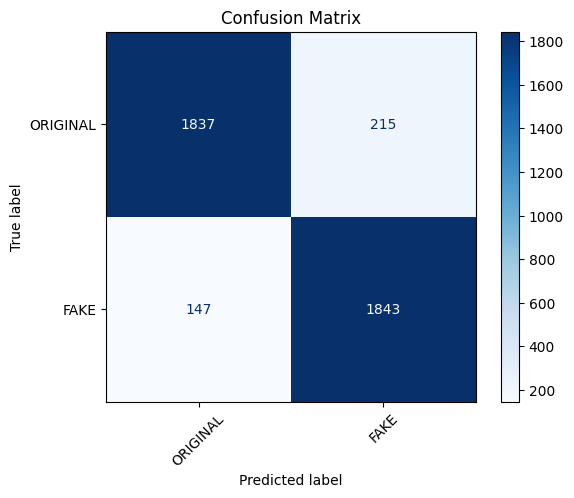

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate Confusion Matrix
cm = confusion_matrix(test_labels, test_predicted_labels)

# Display the confusion matrix
print("\nConfusion Matrix:\n")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ORIGINAL', 'FAKE'])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()
